# Milestone 3 : Exploratory Data Analysis

In [1]:
import ipykernel
from db_utils import RDSDatabaseConnector
from db_utils import load_dataframe
from EDA_classes import DataTransform
from EDA_classes import DataFrameInfo
from EDA_classes import Plotter
from EDA_classes import DataframeTransform

import pandas as pd
from scipy.stats import chi2_contingency # type: ignore
from scipy.stats import normaltest # type: ignore
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.stats import linregress # type: ignore

connect = RDSDatabaseConnector()
failure_df = load_dataframe()



### Task 1 : Convert Columns to correct format
Now that you have familiarised yourself with the data we want to alter any columns that aren't in the correct format. Are there columns that could be represented better numerically, are dates in the correct format, should some columns be categorical? Are there any excess symbols in the data?

If there are columns which you think should be converted into a different format, create a DataTransform class to handle these conversions. Within the DataTransform class add methods which you can apply to your DataFrame columns to perform any required conversions.

In [2]:
transform_dataset = DataTransform(failure_df)
transform_dataset.auto_to_boolean()
transform_dataset.manual_to_categorical('Type')

### Task 2 : Create DataframeInfo class

After converting your columns to a more appropriate format you may want to develop a class to extract information from the DataFrame and its columns. Create a DataFrameInfo class which will contain methods that generate useful information about your DataFrame.


Some useful utility methods you might want to create that are often used for EDA tasks are:

- Describe all columns in the DataFrame to check their data types
- Extract statistical values: median, standard deviation and mean from the columns and the DataFrame
- Count distinct values in categorical columns
- Print out the shape of the DataFrame
- Generate a count/percentage count of NULL values in each column
- Any other methods you may find useful
Creating a class like this will be useful in the future since these are common tasks for performing EDA on any dataset.

In [3]:
info = DataFrameInfo(failure_df)

### Task 3 : Remove/impute missing values in the data
An important EDA task is to impute or remove missing values from the dataset. Missing values can occur due to a variety of reasons such as data entry errors or incomplete information.

During this task, you will first identify the variables with missing values and determine the percentage of missing values in each variable. Depending on the extent of missing data, you may choose to either impute the missing values or remove them from the dataset.

If the percentage of missing data is relatively small, you may choose to impute the missing values using statistical methods such as mean or median imputation. Alternatively, if the percentage of missing data is large or if the missing data is not missing at random, you may choose to remove the variables or rows with missing data entirely.

#### Step 1 : Create Plotter and DataTransform Classes (find in EDA_classes)
- A Plotter class to visualise insights from the data
- A DataFrameTransformclass to perform EDA transformations on your data

In [4]:
plot = Plotter(failure_df)
transform = DataframeTransform(failure_df)

#### Step 2 : Use a method/function to determine the amount of NULLs in each column. Determine which columns should be dropped and drop them.

In [5]:
info.percentage_null()
print(info.find_columns_with_missing_values())

Percentage of missing values in each column:
UDI                        0.00
Product ID                 0.00
Type                       0.00
Air temperature [K]        8.38
Process temperature [K]    8.81
Rotational speed [rpm]     0.00
Torque [Nm]                0.00
Tool wear [min]            4.84
Machine failure            0.00
TWF                        0.00
HDF                        0.00
PWF                        0.00
OSF                        0.00
RNF                        0.00
dtype: float64
['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']


The three columns with missing values are Tool wear, Air temp and Process temp which are all numerical columns
The percentage of missing values does not exceed 10% in any of the columns so there is no reason to drop any columns

#### Step 3 : Within your DataFrameTransform class create a method which can impute your DataFrame columns. 
Decide whether the column should be imputed with the median or the mean and impute the NULL values.

We need to determine if the missing data is missing at random or not missing at random as this will determine whether we choose to remove rows or impute data.

First lets get an overview of the correlation between the numerical columns

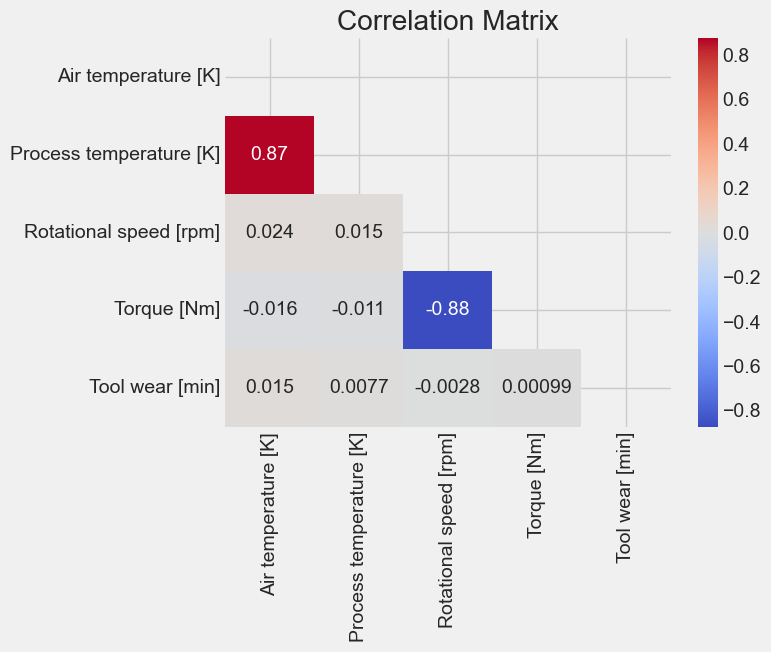

In [6]:
plot.correlation_matrix()

From the heatmap we can see that:
- Air Temperature and Process Temperature are strongly correlated as expected
- Tool wear doesn't have strong correlation with any other values

Due to having no significant correlation, we can probably risk concluding that Tool wear is missing at random and that we can impute the missing values.
To decide what to impute the missing value with, lets look at the distribution...

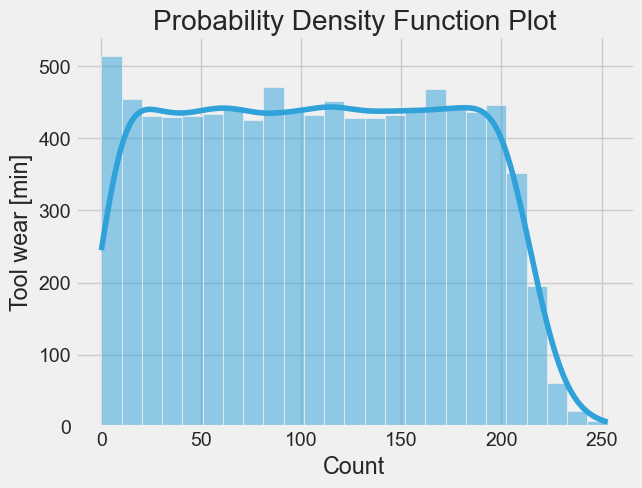


Tool wear [min] 
mean : 108.21952501050862 
median : 108.0 
standard deviation : 63.61253442704996


In [7]:
plot.kde_plot('Tool wear [min]')
info.manual_extract_stats('Tool wear [min]')

The distribution looks fairly flat and the mean and median are very similar so we could impute with either

In [8]:
transform.impute_with_mean('Tool wear [min]')

Lets further investigate the correlation between process and air temp

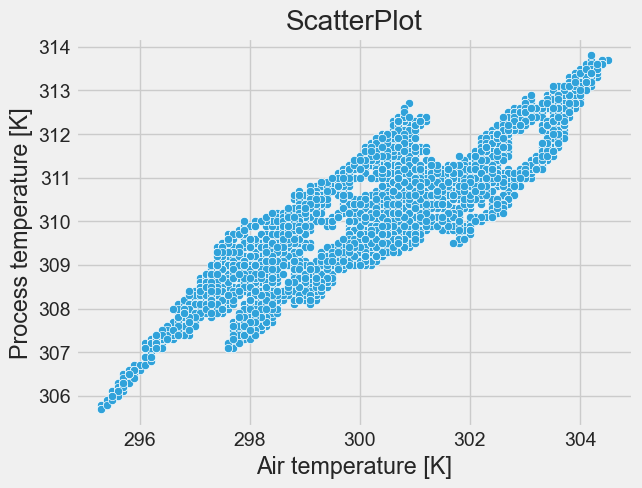

In [9]:
plot.scatter_plot('Air temperature [K]', 'Process temperature [K]')

One potential approach we could take, since they are strongly correlated, is to use the mean of the difference to impute the missing values

This method would require us to drop rows where both air and process temp are missing

In [10]:
temp = ['Air temperature [K]', 'Process temperature [K]']
temp_df = failure_df[temp]
temp_df['difference'] = temp_df['Process temperature [K]'] - temp_df['Air temperature [K]']
temp_info = DataFrameInfo(temp_df)
temp_info.extract_stats()
temp_df = temp_df.dropna(subset=['Process temperature [K]','Air temperature [K]'], how='all')
temp_df['Process temperature [K]'] = temp_df['Process temperature [K]'].fillna(temp_df['Air temperature [K]'] + temp_df['difference'].mean())
temp_df['Air temperature [K]'] = temp_df['Air temperature [K]'].fillna(temp_df['Process temperature [K]'] - temp_df['difference'].mean())


Air temperature [K] 
mean : 300.0085898275486 
median : 300.1 
standard deviation : 1.9991476728921096

Process temperature [K] 
mean : 310.0115802171291 
median : 310.1 
standard deviation : 1.4801381939399598

difference 
mean : 10.003863636363635 
median : 9.800000000000011 
standard deviation : 0.9998746903510132


Alternatively...

Use the D’Agostino’s K^2 Test (goodness-of-fit measure of departure from normality) to test for normal distribution


Air temperature [K] 
mean : 300.0085898275486 
median : 300.1 
standard deviation : 1.9991476728921096


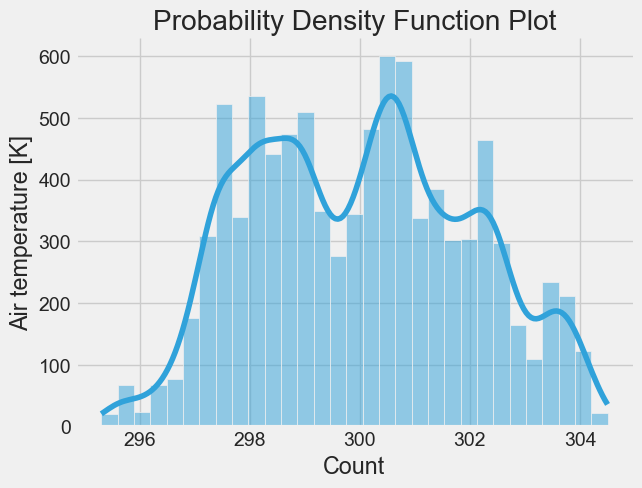

Statistics=928.181, p=0.000


In [11]:
data = failure_df['Air temperature [K]']
info.manual_extract_stats('Air temperature [K]')
plot.kde_plot('Air temperature [K]')
# D’Agostino’s K^2 Test
stat, p = normaltest(data, nan_policy='omit')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Air temperature looks to be normally distributed and the median and mean are very similar so we can impute with either

In [12]:
transform.impute_with_mean('Air temperature [K]')


Process temperature [K] 
mean : 310.0115802171291 
median : 310.1 
standard deviation : 1.4801381939399598


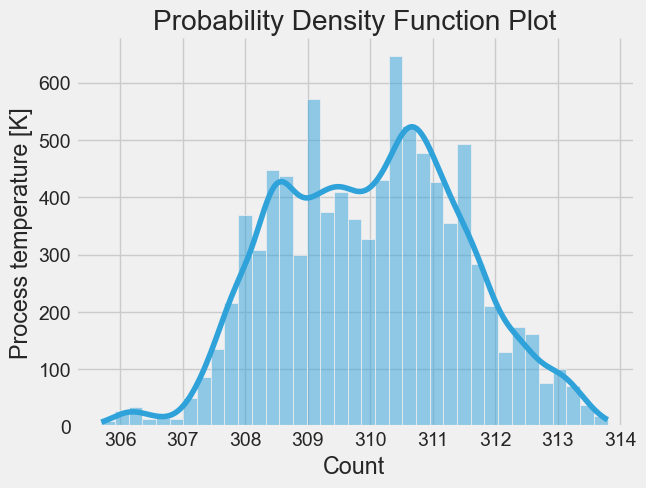

Statistics=181.218, p=0.000


In [13]:
data = failure_df['Process temperature [K]']
info.manual_extract_stats('Process temperature [K]')
plot.kde_plot('Process temperature [K]') 
# D’Agostino’s K^2 Test
stat, p = normaltest(data, nan_policy='omit')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Process temperature looks normally distributed and the median and mean are very similar so we can impute with either

In [14]:
transform.impute_with_mean('Process temperature [K]')

#### Step 4: Run your NULL checking method/function again to check that all NULLs have been removed. 
Generate a plot by creating a method in your Plotter class to visualise the removal of NULL values. ???

In [15]:
info.percentage_null()

Percentage of missing values in each column:
UDI                        0.0
Product ID                 0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
Machine failure            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
dtype: float64


### Task 4 : Perform transformations on skewed columns
Skewed data can lead to biased models and inaccurate results, so it's important to address this issue before proceeding with any analysis.

#### Step 1 : Firstly you will need to identify the skewed columns in the data. 
This can be done using standard Pandas methods. You then need to determine a threshold for the skewness of the data, over which a column will be considered skewed. You should also visualise the data using your Plotter class to analyse the skew.

Skew of Air temperature [K] column is 0.12384192893843705
Skew of Process temperature [K] column is 0.006837210670394168
Skew of Rotational speed [rpm] column is 1.993171004713752


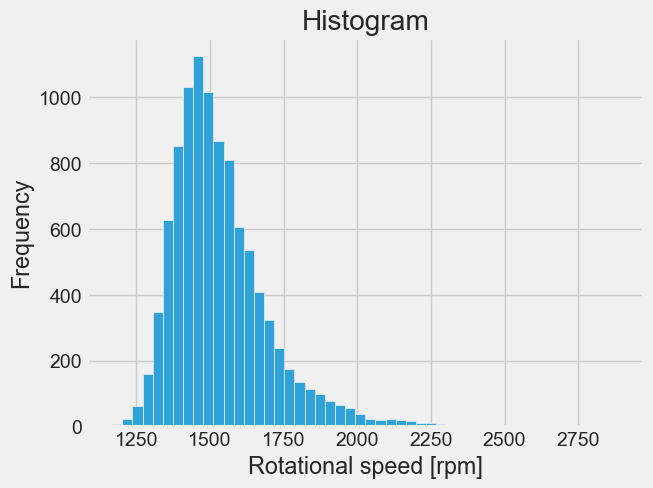

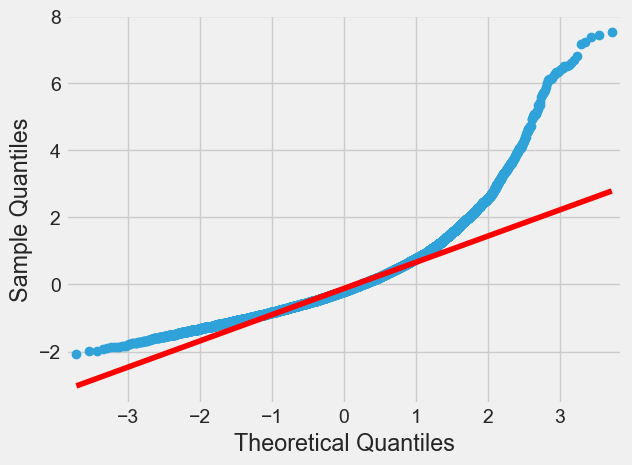

Skew of Torque [Nm] column is -0.009516595840058564
Skew of Tool wear [min] column is 0.021715315952332365
['Rotational speed [rpm]']


In [16]:
column_names = list(failure_df.columns)
numeric_features = [col for col in failure_df.columns[1:]
                    if failure_df[col].dtype == 'float64' or failure_df[col].dtype == 'int64']

columns_with_high_skew = []
for column in numeric_features:
    print(f"Skew of {column} column is {failure_df[column].skew()}")
    if failure_df[column].skew() > 1 or failure_df[column].skew() < -1:
        plot.histogram(column)
        plot.qq_plot(column)
        columns_with_high_skew.append(column)

print(columns_with_high_skew)

From looking at the histograms of the different columns, I've decided that the threshold for skewness should be 1/-1

The main contender for skew is Rotational speed which has a big gap between the 3rd quartile and the max

Looking at the histogram and qq-plot we can see is heavily right skewed


#### Step 2 : Once the skewed columns are identified, you should perform transformations on these columns to determine which transformation results in the biggest reduction in skew. 
Create the the method to transform the columns in your DateFrameTransform class.

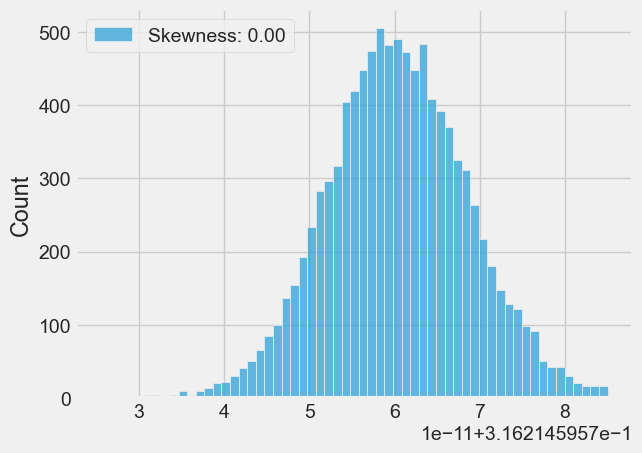

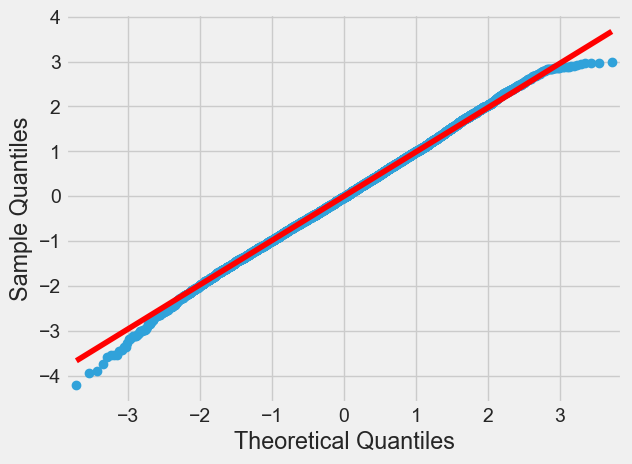

In [17]:
# plot.skew_log("Rotational speed [rpm]")
plot.skew_boxcox("Rotational speed [rpm]")

#### Step 3 : Apply the identified transformations to the columns to reduce their skewness.

In [18]:
# transform.correct_skew_log("Rotational speed [rpm]")
transform.correct_skew_boxcox("Rotational speed [rpm]")

#### Step 4 : Visualise the data to check the results of the transformation have improved the skewness of the data.

Skew of Rotational speed [rpm] column is 0.0


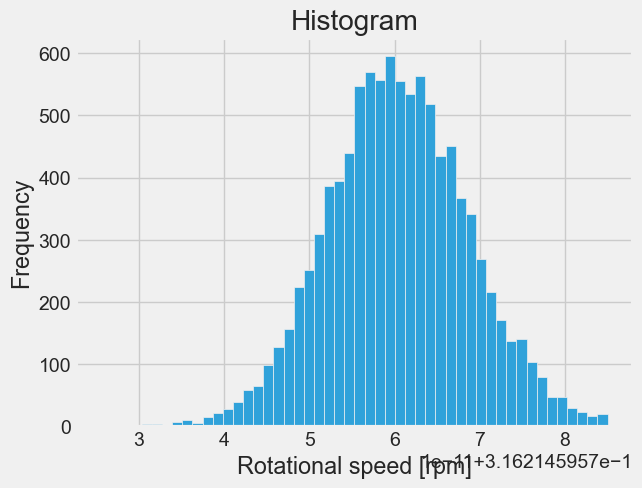

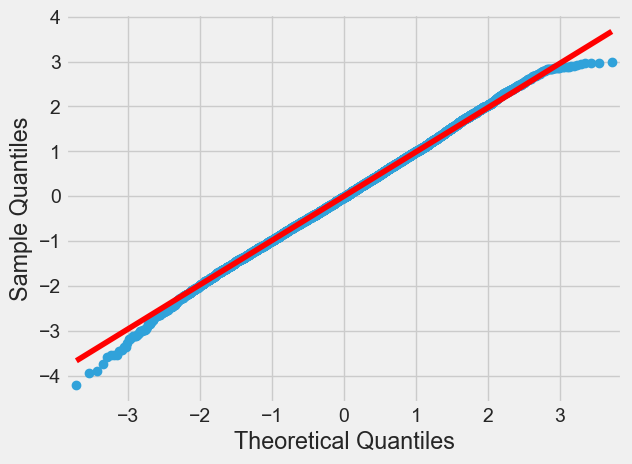

In [19]:
for column in columns_with_high_skew:
    print(f"Skew of {column} column is {failure_df[column].skew()}")
    plot.histogram(column)
    plot.qq_plot(column)

#### Step 5 : At this point you may want to save a separate copy of your DataFrame to compare your results.

In [20]:
connect.save_edited_dataframe(failure_df)

### Task 5 : Remove outliers from the data

Removing outliers from the dataset will improve the quality and accuracy of the analysis as outliers can distort the analysis results. You will need to first identify the outliers and then use a method to remove them.

#### Step 1 : First visualise your data using your Plotter class to determine if the columns contain outliers.

Visual methods for detecting outliers are box plots and histograms

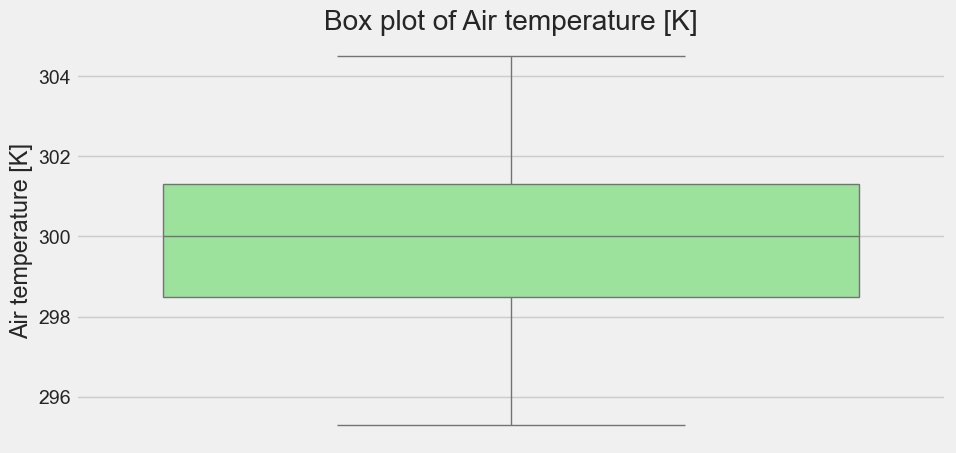

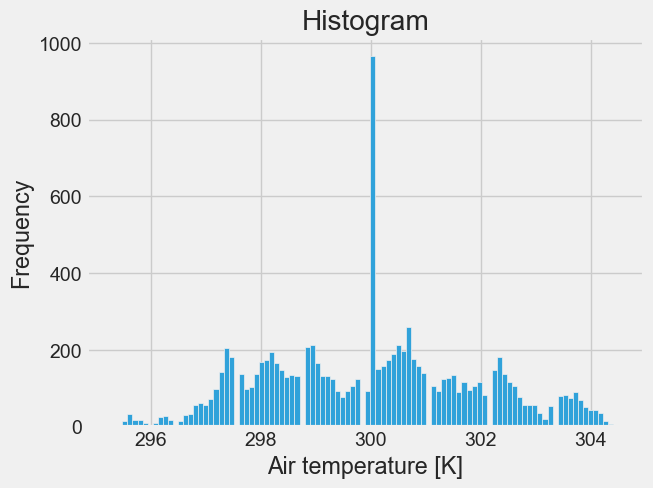

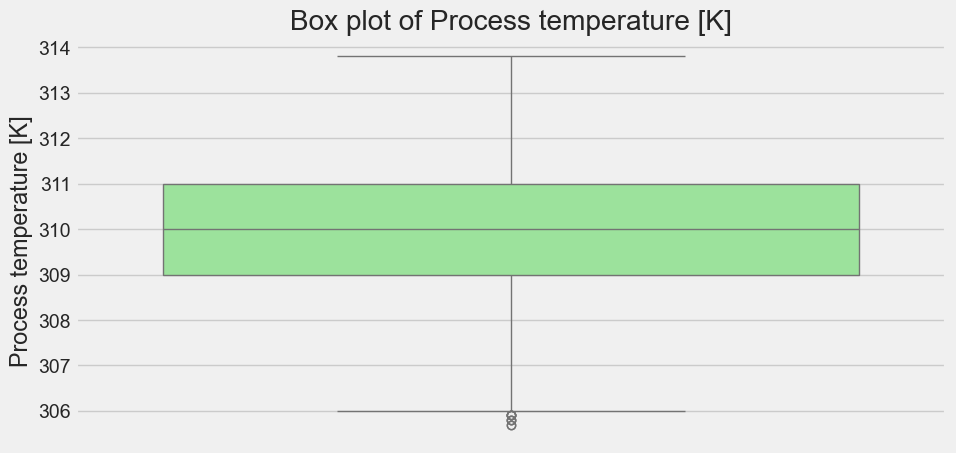

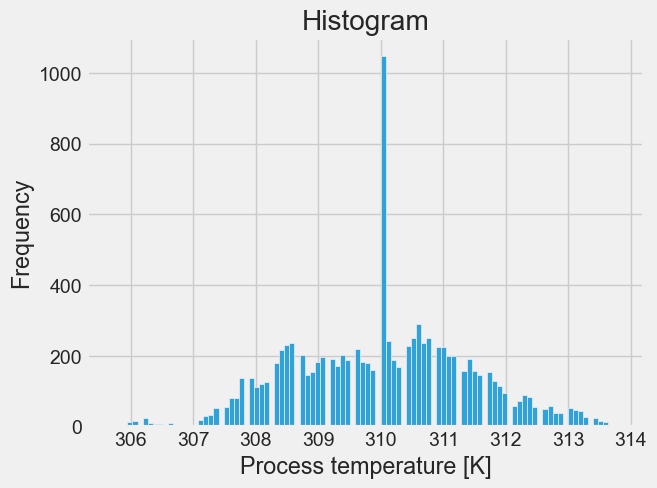

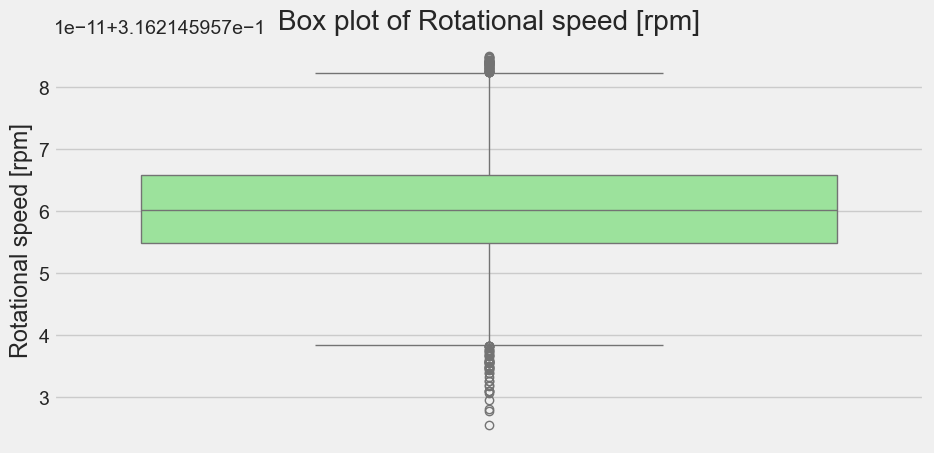

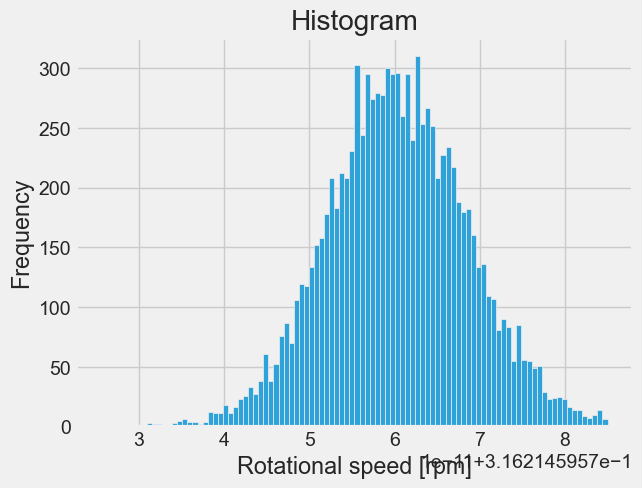

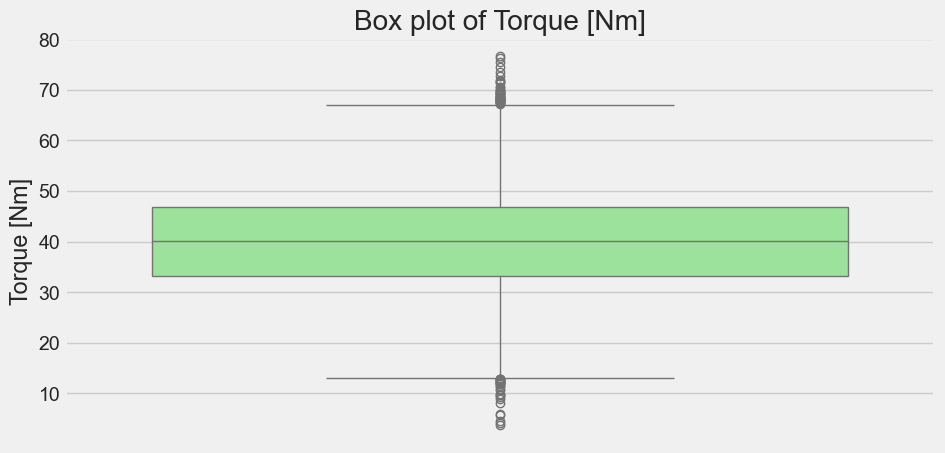

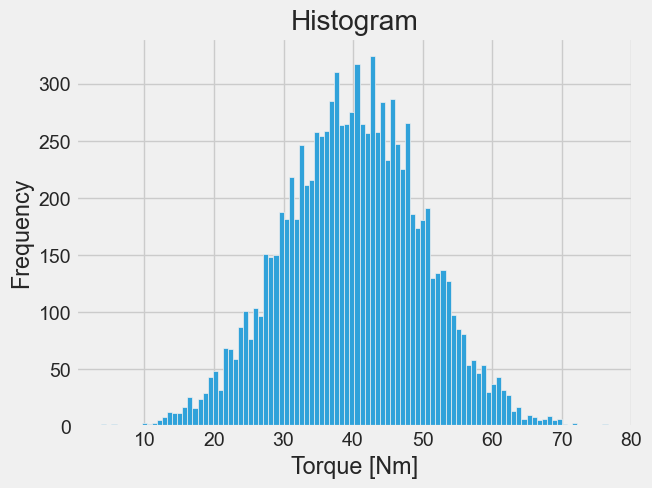

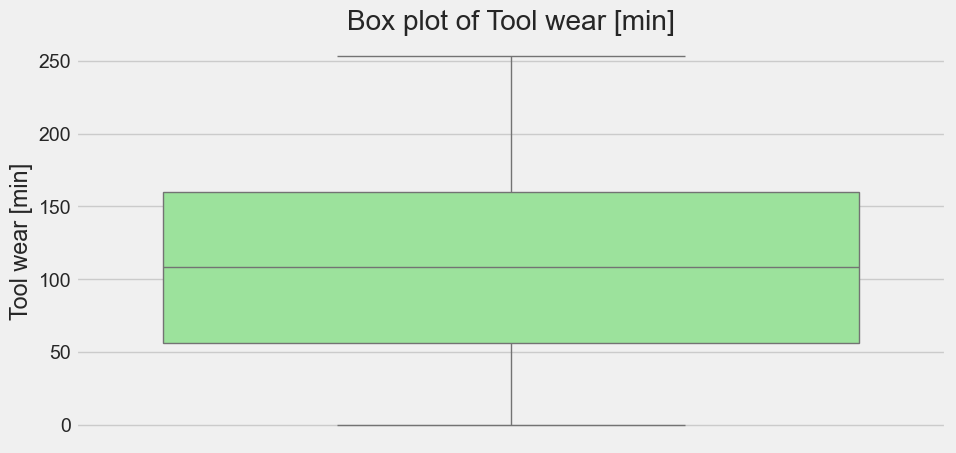

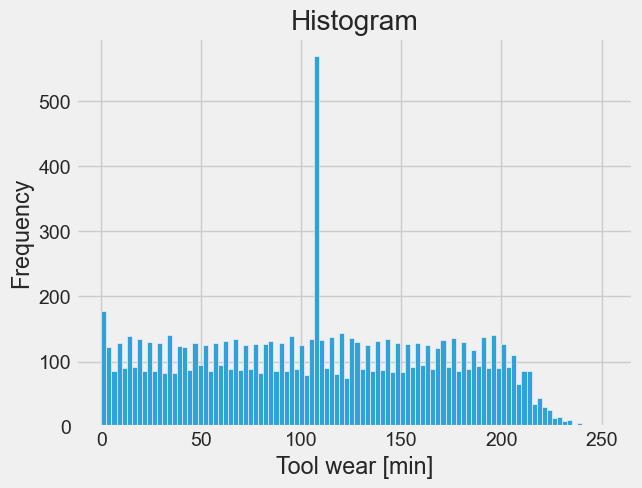

In [21]:
plot.box_plot('Air temperature [K]') 
plot.histogram('Air temperature [K]', 100) 
plot.box_plot('Process temperature [K]')
plot.histogram('Process temperature [K]', 100)
plot.box_plot('Rotational speed [rpm]')
plot.histogram('Rotational speed [rpm]', 100)
plot.box_plot('Torque [Nm]')
plot.histogram('Torque [Nm]', 100)
plot.box_plot('Tool wear [min]')
plot.histogram('Tool wear [min]', 100)

From initial visual inspection, we can determine that:
- Air temperature [K] and Tool wear [min] have 0 potential outliers 
- Process temperature [K] may have a couple on the lower end but they are only just outside the whiskers of the boxplot
- Rotation speed [rpm] and Torque [Nm] both seem to have quite alot of potential outliers on the boxplot

Statistical methods are z-score and Interquartile range

In [23]:
for column in numeric_features:
    mean = failure_df[column].mean()
    std = failure_df[column].std()
    print(f'Mean of {column} is {mean} and standard deviation is {std}')
    z_scores = (failure_df[column] - mean) / std
    failure_df_z_scores = failure_df
    failure_df_z_scores['z_scores'] = z_scores
    subset = failure_df_z_scores.loc[failure_df_z_scores['z_scores'] > 3, [column, 'z_scores']]
    if len(subset) == 0:
        print(f'{column} has 0 potential outliers \n')
    else:
        print(f'Number of potential outliers is : {len(subset)} \n')

Mean of Air temperature [K] is 300.0085898275486 and standard deviation is 1.913542150675932
Air temperature [K] has 0 potential outliers 

Mean of Process temperature [K] is 310.0115802171291 and standard deviation is 1.4134282758089383
Process temperature [K] has 0 potential outliers 

Mean of Rotational speed [rpm] is 0.31621459576033567 and standard deviation is 8.262236529213988e-12
Rotational speed [rpm] has 0 potential outliers 

Mean of Torque [Nm] is 39.986909999999995 and standard deviation is 9.968933725121389
Number of potential outliers is : 14 

Mean of Tool wear [min] is 108.21952501050862 and standard deviation is 62.053861357664566
Tool wear [min] has 0 potential outliers 



The Z-Score is a statistical measurement that describes a data point's position relative to the mean of a group of values measured in terms of standard deviations. 

Data points with a Z-Score having a high absolute value, typically beyond a threshold like 2 or 3, are often considered outliers as they significantly deviate from the average

Summary: Using a theshold of 3, Torque has 14 potential outliers

In [25]:
for column in numeric_features:
    Q1 = failure_df[column].quantile(0.25)
    Q3 = failure_df[column].quantile(0.75)
    IQR = Q3 - Q1
    print(f"Q1 (25th percentile): {Q1}")
    print(f"Q3 (75th percentile): {Q3}")
    print(f"IQR: {IQR}")
    outliers = failure_df[(failure_df[column] < (Q1 - 1.5 * IQR)) | (failure_df[column] > (Q3 + 1.5 * IQR))]
    if len(outliers) > 0:
        print(f'The number of potential outliers : {len(outliers)}')
        print(f"Outliers of {column} column:")
        print('\n')
    else:
        print(f'{column} has 0 outliers \n')

Q1 (25th percentile): 298.5
Q3 (75th percentile): 301.3
IQR: 2.8000000000000114
Air temperature [K] has 0 outliers 

Q1 (25th percentile): 309.0
Q3 (75th percentile): 311.0
IQR: 2.0
The number of potential outliers : 10
Outliers of Process temperature [K] column:


Q1 (25th percentile): 0.3162145957548495
Q3 (75th percentile): 0.31621459576584826
IQR: 1.0998757460356501e-11
The number of potential outliers : 90
Outliers of Rotational speed [rpm] column:


Q1 (25th percentile): 33.2
Q3 (75th percentile): 46.8
IQR: 13.599999999999994
The number of potential outliers : 69
Outliers of Torque [Nm] column:


Q1 (25th percentile): 56.0
Q3 (75th percentile): 160.0
IQR: 104.0
Tool wear [min] has 0 outliers 



Values that fall below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR are typically classified as outliers, as they lie outside the common range of variability in the data.

Summary:
- Process temp has 10 potential outliers
- Rotational speed has 90 potential outliers
- Torque has 69 potential outliers

#### Step 2 : Once identified use a method to transform or remove the outliers from the dataset. Build this method in your DataFrameTransform class.

In [26]:
transform.remove_outliers_IQR('Rotational speed [rpm]', 1.5)
transform.remove_outliers_IQR('Torque [Nm]', 1.5)

#### Step 3 : With the outliers transformed/removed re-visualise your data with you Plotter class to check that the outliers have been correctly removed.

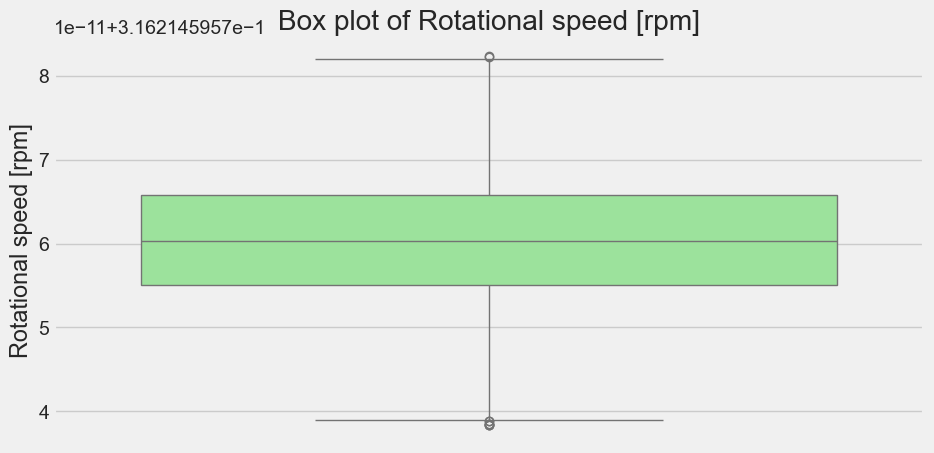

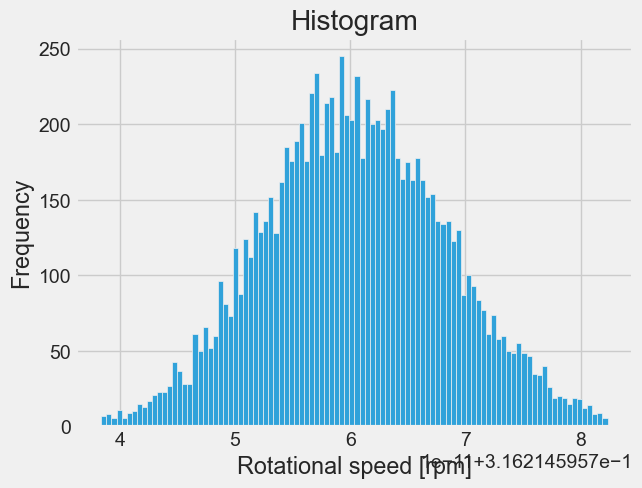

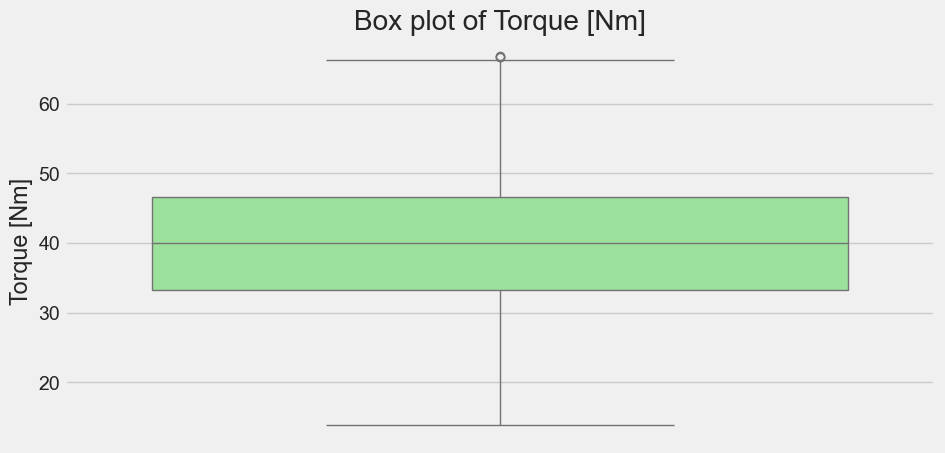

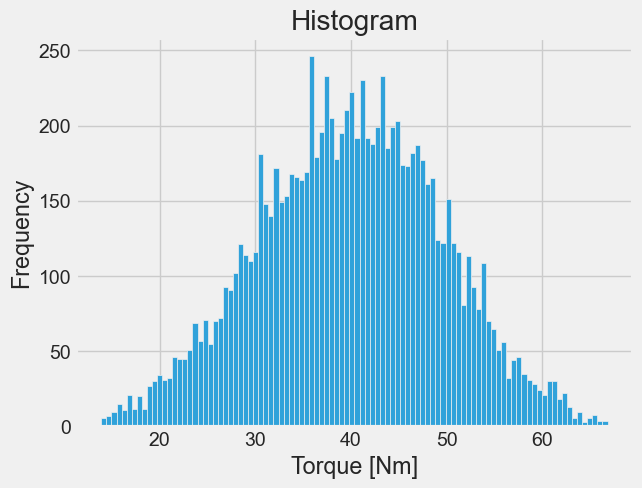

In [27]:
plot.box_plot('Rotational speed [rpm]')
plot.histogram('Rotational speed [rpm]', 100)

plot.box_plot('Torque [Nm]')
plot.histogram('Torque [Nm]', 100)

We might also want to check for correlation between columns investigate any data points that deviate significantly from the general trend, indicating potential outliers.

Visual methods for detecting outliers are scatter plots and regression lines

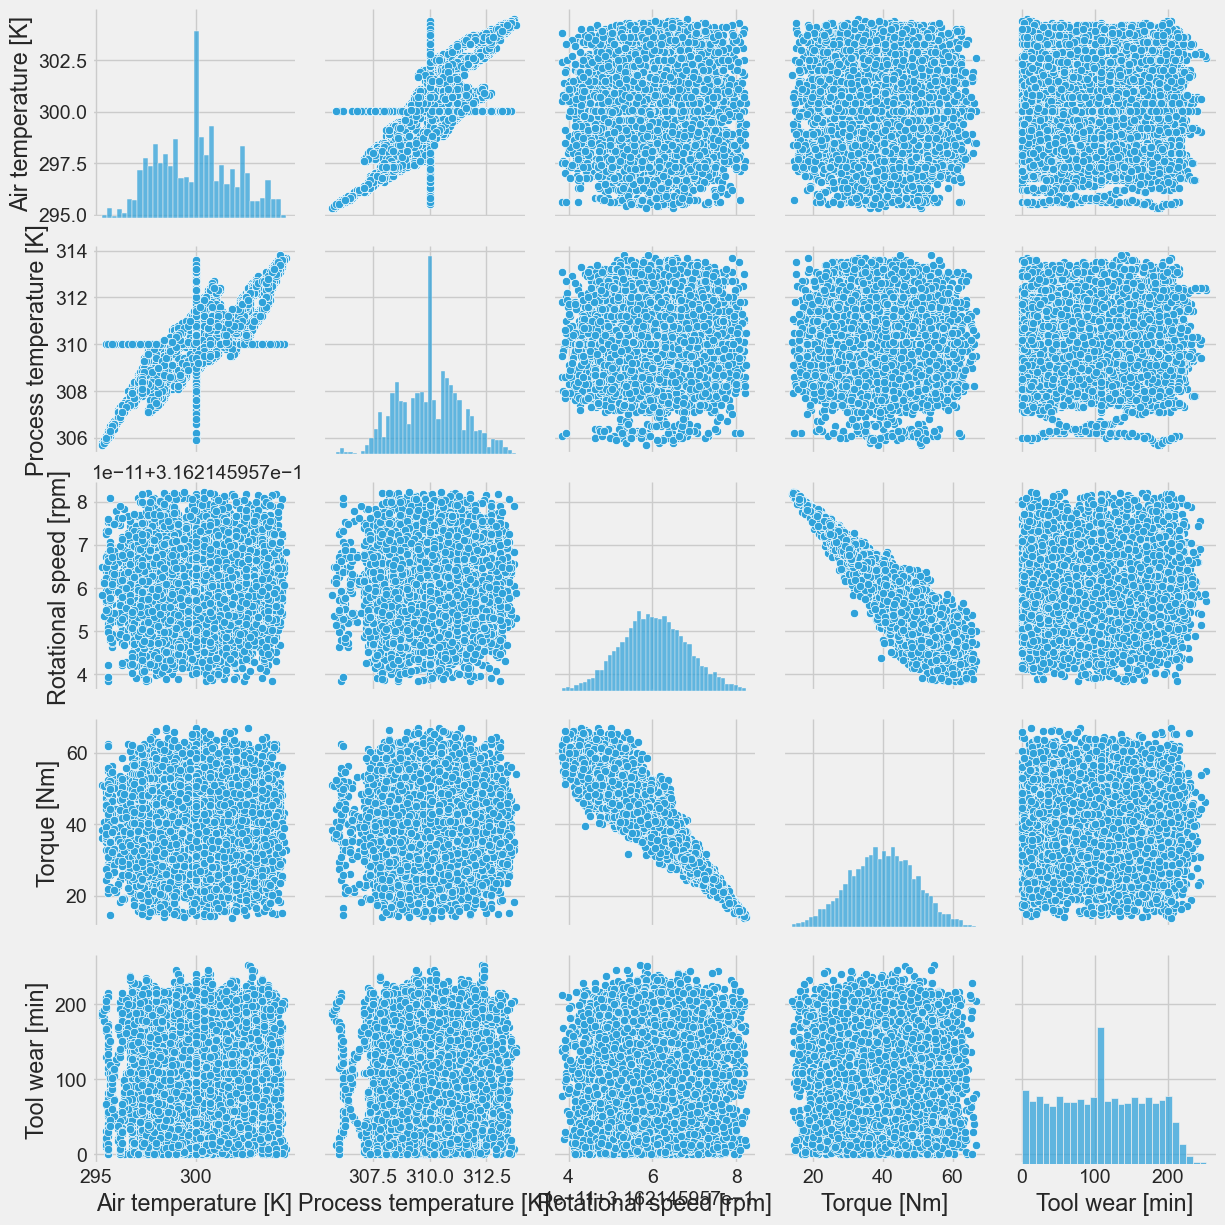

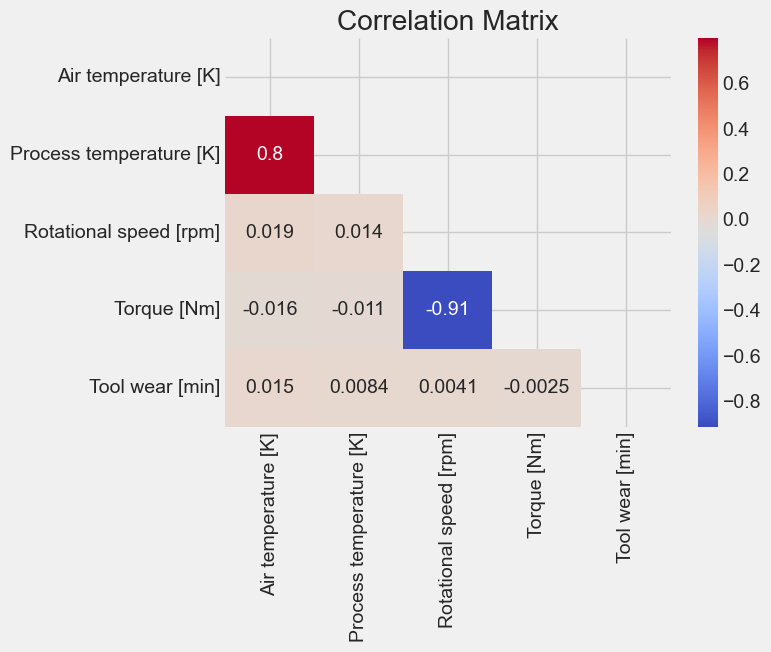

In [28]:
plot.pair_plot()
plot.correlation_matrix()

There is a strong positive correlation between Air temperature and Process temperature and a strong negative correlation between Rotational speed and Torque

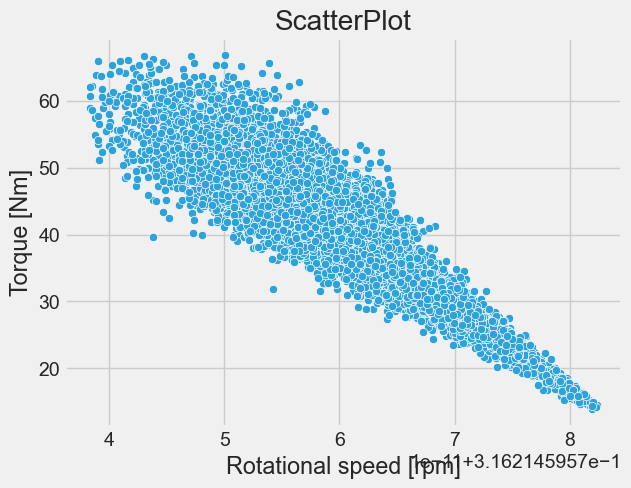

LinregressResult(slope=-1106381045786.041, intercept=349853835190.1234, rvalue=-0.914539966994658, pvalue=0.0, stderr=4924580288.408727, intercept_stderr=1557224165.188849)
slope of regression line:  -1106381045786.041
Mean Squared Error (MSE) of the regression line:  14.975800614895885


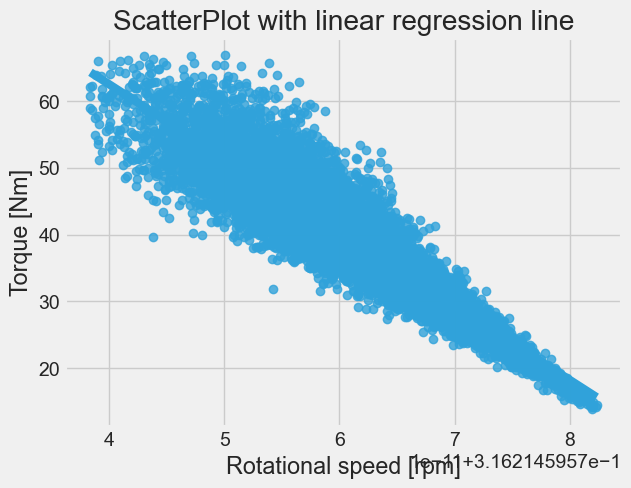

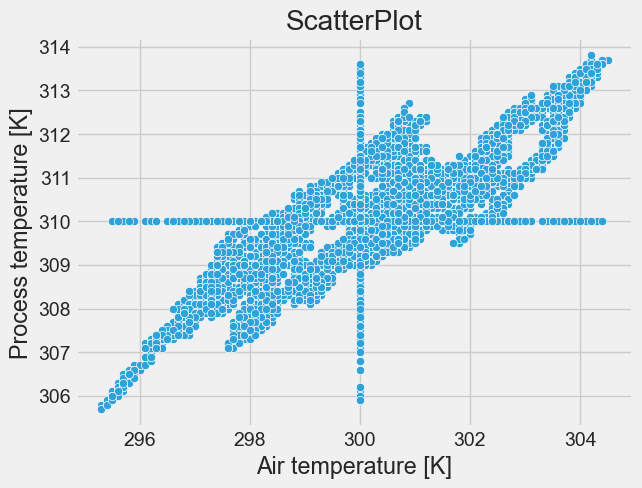

LinregressResult(slope=0.5891186858338239, intercept=133.27132511324493, rvalue=0.7977512143360123, pvalue=0.0, stderr=0.004481222618765897, intercept_stderr=1.3444256705830055)
slope of regression line:  0.5891186858338239
Mean Squared Error (MSE) of the regression line:  0.7258593009914078


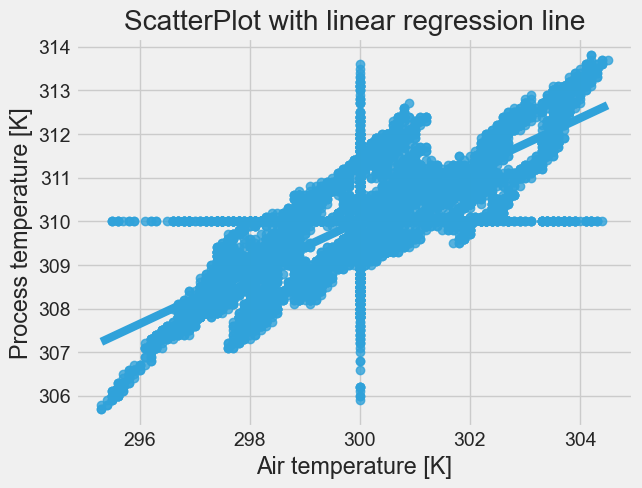

0.7977512143360123

In [29]:
plot.scatter_plot('Rotational speed [rpm]', 'Torque [Nm]')
plot.scatter_with_lin_regression('Rotational speed [rpm]', 'Torque [Nm]')

plot.scatter_plot('Air temperature [K]', 'Process temperature [K]')
plot.scatter_with_lin_regression('Air temperature [K]', 'Process temperature [K]')

There are significant amount of ouliers in the scatterplot for Air temperature against Process temperature due to filling in null values...

### Task 6 : Dropping overly correlated columns

Highly correlated columns in a dataset can lead to multicollinearity issues, which can affect the accuracy and interpretability of models built on the data. In this task, you will identify highly correlated columns and remove them to improve the quality of the data.

#### Step 1 : First compute the correlation matrix for the dataset and visualise it.

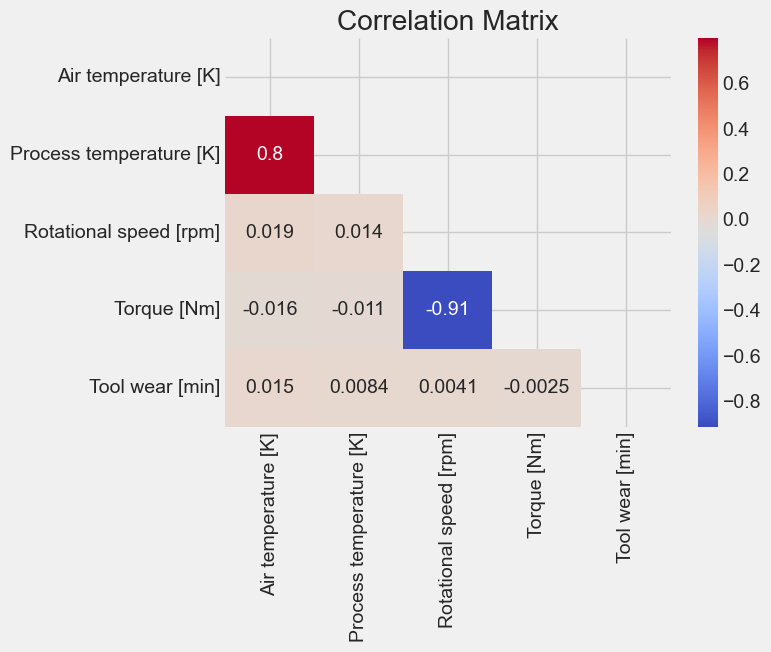

In [30]:
plot.correlation_matrix()

#### Step 2 : Identify which columns are highly correlated. You will need to decide on a correlation threshold and to remove all columns above this threshold.

There is a strong positive correlation between Air and Process temp and a strong negative correlation between Rotational speed and Torque

In [31]:
columns_with_high_correlation = []
for column_1 in numeric_features:
    for column_2 in numeric_features:
        if column_1 == column_2:
            continue
        else:
            slope, intercept, r_value, p_value, std_err = linregress(failure_df[column_1], failure_df[column_2])
            if round(r_value, 1) >= 0.8:
                columns_with_high_correlation.append(column_1)
print(columns_with_high_correlation)

['Air temperature [K]', 'Process temperature [K]']


#### Step 3 : Decide which columns can be removed based on the results of your analysis.

We can remove either Air or Process temp in this case but since Process temperature is the temperature the machine was operating at during production while air temperature is just the average room temperature, we should keep Process temperature

#### Step 4 : Remove the highly correlated columns from the dataset.

In [32]:
failure_df.drop('Air temperature [K]', axis=1, inplace=True)
print(failure_df.head(5))

    UDI Product ID Type  Process temperature [K]  Rotational speed [rpm]  \
0  3416     L50595    L                    310.4                0.316215   
1  7130     L54309    L                    310.0                0.316215   
2  2320     M17179    M                    308.8                0.316215   
3  9601     M24460    M                    310.0                0.316215   
4   614     L47793    L                    309.9                0.316215   

   Torque [Nm]  Tool wear [min]  Machine failure    TWF    HDF    PWF    OSF  \
0         36.9            133.0            False  False  False  False  False   
1         31.0            107.0            False  False  False  False  False   
2         33.5            185.0            False  False  False  False  False   
3         45.3             58.0            False  False  False  False  False   
4         30.0             53.0            False  False  False  False  False   

     RNF  z_scores  
0  False  0.399338  
1  False -0.019653  